In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from animate import *

In [9]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [5]:
def computemjj_pd(event):
    px1 = np.array(event['pxj1'])
    py1 = np.array(event['pyj1'])
    pz1 = np.array(event['pzj1'])
    mj1 = np.array(event['mj1'])
    Ej1 = np.sqrt((px1**2 + py1**2 + pz1**2) + mj1**2)

    px2 = np.array(event['pxj2'])
    py2 = np.array(event['pyj2'])
    pz2 = np.array(event['pzj2'])
    mj2 = np.array(event['mj2'])
    Ej2 = np.sqrt((px2**2 + py2**2 + pz2**2) + mj2**2)

    p4_j1 = np.array([px1, py1, pz1, Ej1]).transpose()
    p4_j2 = np.array([px2, py2, pz2, Ej2]).transpose()
    
    p4_jj = p4_j1 + p4_j2
    mjj = np.sqrt((p4_jj**2 * np.array([-1, -1, -1, 1])).sum(axis=1))
    return mjj

In [9]:
mjj

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [15]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

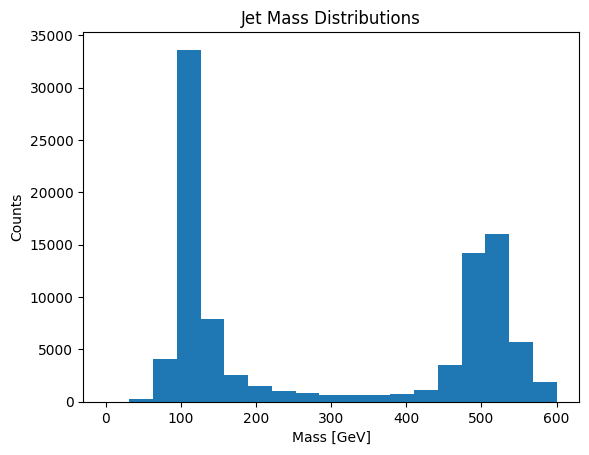

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [112]:
# def computemjj_pd(event):
#     px1 = event[["pxj1"]].to_numpy()
#     py1 = event[["pyj1"]].to_numpy()
#     pz1 = event[["pzj1"]].to_numpy()
#     pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
#     px2 = event[["pxj2"]].to_numpy()
#     py2 = event[["pyj2"]].to_numpy()
#     pz2 = event[["pzj2"]].to_numpy()
#     pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
#     m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
#     return np.array(np.sqrt(m2)).flatten()

In [115]:
computemjj_pd(df_QCD)

/tmp/ipykernel_340405/3658239227.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.array(np.sqrt(m2)).flatten()


array([3355.02554618, 2339.42558763, 2476.53829533, ..., 3867.9955467 ,
       2882.70480346, 2279.14046694])

In [3]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [10]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-6
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+epsilon))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+epsilon))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+epsilon),stau2_m_m/(stau1_m_m+epsilon)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_order1", x_array)

In [11]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [12]:
np.shape(x[0,0])

(121352, 4)

In [16]:
num_signal = 0
for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        num_signal += len(x[m1, m2])
num_signal

9774732

In [8]:
x_data = np.concatenate([x[0,0],x[1,1]])
y_data = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.5)

In [109]:
# x_data = np.concatenate([x[0,0],x[5,1]])
# y_data = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[5,1]))])
# X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.5)

In [142]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

In [143]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_793 (Dense)           (None, 512)               2560      
                                                                 
 dense_794 (Dense)           (None, 256)               131328    
                                                                 
 dense_795 (Dense)           (None, 128)               32896     
                                                                 
 dense_796 (Dense)           (None, 1)                 129       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [144]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [145]:
myhistory = model_dedicated.fit(X_train, Y_train, epochs=config.epoch,
                                validation_data=(X_val, Y_val),
                                batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.3180 - accuracy: 0.8799INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.3036 - accuracy: 0.8853 - val_loss: 0.2607 - val_accuracy: 0.9031
Epoch 2/1000
64/88 [====================>.........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9063INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.2516 - accuracy: 0.9065 - val_loss: 0.2499 - val_accuracy: 0.9049
Epoch 3/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.2363 - accuracy: 0.9108INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2348 - accuracy: 0.9113 - val_loss: 0.2252 - val_accuracy: 0.9155
Epoch 4/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.2180 - accuracy: 0.9179INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2176 - accuracy: 0.9181 - val_loss: 0.2097 - val_accuracy: 0.9225
Epoch 5/1000
80/88 [==========================>...] - ETA: 0s - loss: 0.2073 - accuracy: 0.9211INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2065 - accuracy: 0.9216 - val_loss: 0.2044 - val_accuracy: 0.9248
Epoch 6/1000
85/88 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9241INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.2014 - accuracy: 0.9241 - val_loss: 0.2038 - val_accuracy: 0.9255
Epoch 7/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9242 - val_loss: 0.2068 - val_accuracy: 0.9226
Epoch 8/1000
61/88 [===================>..........] - ETA: 0s - loss: 0.1993 - accuracy: 0.9246INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1980 - accuracy: 0.9251 - val_loss: 0.1993 - val_accuracy: 0.9258
Epoch 9/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9258 - val_loss: 0.2035 - val_accuracy: 0.9242
Epoch 10/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9256 - val_loss: 0.2029 - val_accuracy: 0.9249
Epoch 11/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9257 - val_loss: 0.2013 - val_accuracy: 0.9257
Epoch 12/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9254 - val_loss: 0.2036 - val_accuracy: 0.9241
Epoch 13/1000
67/88 [=====================>........] - ETA: 0s - loss: 0.1971 - accuracy: 0.9253INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1981 - accuracy: 0.9246 - val_loss: 0.1992 - val_accuracy: 0.9258
Epoch 14/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1963 - accuracy: 0.9262 - val_loss: 0.2000 - val_accuracy: 0.9258
Epoch 15/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9262 - val_loss: 0.1994 - val_accuracy: 0.9262
Epoch 16/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1960 - accuracy: 0.9259 - val_loss: 0.2019 - val_accuracy: 0.9250
Epoch 17/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.9254 - val_loss: 0.1992 - val_accuracy: 0.9262
Epoch 18/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.9260 - val_loss: 0.2009 - val_accuracy: 0.9248
Epoch 19/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.9252 - val_loss: 0.1996 - val_accuracy: 0.9262
Epoch 20/100

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 10ms/step - loss: 0.1949 - accuracy: 0.9267 - val_loss: 0.1986 - val_accuracy: 0.9260
Epoch 21/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1957 - accuracy: 0.9266 - val_loss: 0.2000 - val_accuracy: 0.9252
Epoch 22/1000
62/88 [====================>.........] - ETA: 0s - loss: 0.1952 - accuracy: 0.9264INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1948 - accuracy: 0.9267 - val_loss: 0.1985 - val_accuracy: 0.9265
Epoch 23/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9268 - val_loss: 0.1988 - val_accuracy: 0.9261
Epoch 24/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.1926 - accuracy: 0.9268INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 2s 21ms/step - loss: 0.1938 - accuracy: 0.9268 - val_loss: 0.1983 - val_accuracy: 0.9266
Epoch 25/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9264 - val_loss: 0.2032 - val_accuracy: 0.9245
Epoch 26/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9265 - val_loss: 0.1987 - val_accuracy: 0.9261
Epoch 27/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1943 - accuracy: 0.9266 - val_loss: 0.1986 - val_accuracy: 0.9265
Epoch 28/1000
61/88 [===================>..........] - ETA: 0s - loss: 0.1921 - accuracy: 0.9267INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1938 - accuracy: 0.9265 - val_loss: 0.1976 - val_accuracy: 0.9264
Epoch 29/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.1943 - accuracy: 0.9268 - val_loss: 0.1991 - val_accuracy: 0.9258
Epoch 30/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9270 - val_loss: 0.1976 - val_accuracy: 0.9260
Epoch 31/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9268 - val_loss: 0.1990 - val_accuracy: 0.9259
Epoch 32/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.1931 - accuracy: 0.9268 - val_loss: 0.2001 - val_accuracy: 0.9253
Epoch 33/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9267 - val_loss: 0.1988 - val_accuracy: 0.9264
Epoch 34/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1935 - accuracy: 0.9272 - val_loss: 0.1987 - val_accuracy: 0.9260
Epoch 35/100

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1928 - accuracy: 0.9272 - val_loss: 0.1976 - val_accuracy: 0.9266
Epoch 36/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1936 - accuracy: 0.9265 - val_loss: 0.2019 - val_accuracy: 0.9245
Epoch 37/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1929 - accuracy: 0.9271 - val_loss: 0.1982 - val_accuracy: 0.9262
Epoch 38/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9264 - val_loss: 0.1998 - val_accuracy: 0.9253
Epoch 39/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9272 - val_loss: 0.1980 - val_accuracy: 0.9266
Epoch 40/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1932 - accuracy: 0.9269 - val_loss: 0.2002 - val_accuracy: 0.9250
Epoch 41/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9267 - val_loss: 0.1991 - val_accuracy: 0.9258
Epoch 42/100

In [146]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▄▅▆▇▇▇████▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇▇█▇█▇█▇███▇███▇███▇████████████▇████
val_loss,█▇▄▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.92785
best_epoch,34
best_val_loss,0.1976
epoch,44
loss,0.19201
val_accuracy,0.9261


In [117]:
y_val_pred = model_dedicated.predict(X_val)
auc = roc_auc_score(Y_val, y_val_pred)

print("AUC:", auc)

2806/2806 [==============================] - 2s 754us/step
AUC: 0.9696640331901925


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [53]:
#model_dedicated.save("model_100_BCE")

INFO:tensorflow:Assets written to: model_100_BCE/assets


In [79]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 2 and j == 2) or (i == 3 and j == 3) or (i == 4 and j == 4) or (i == 5 and j == 5) or (i == 6 and j == 6):
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_ordered_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

Epoch 1/1000
97/97 [==============================] - 1s 4ms/step - loss: 0.3718 - accuracy: 0.8337 - val_loss: 0.3105 - val_accuracy: 0.8645
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.3054 - accuracy: 0.8652 - val_loss: 0.2977 - val_accuracy: 0.8689
Epoch 3/1000
97/97 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.8679 - val_loss: 0.2928 - val_accuracy: 0.8708
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2936 - accuracy: 0.8692 - val_loss: 0.2947 - val_accuracy: 0.8698
Epoch 5/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.8695 - val_loss: 0.2888 - val_accuracy: 0.8726
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.2896 - val_accuracy: 0.8727
Epoch 7/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2922 - accuracy: 0.8703 - val_loss: 0.2978 - val_accuracy: 0.8688
Epoch 

In [77]:
len(tuple_rates_dedicated_ordered_BCE)

6

In [80]:
np.save("tuple_rates_dedicated_ordered_BCE", tuple_rates_dedicated_ordered_BCE)

In [55]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [81]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated_ordered_BCE.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

7

In [78]:
tuple_rates_dedicated.keys()

dict_keys([(0.5, 0.5), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)])

183/183 [==============================] - 0s 690us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 653us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 664us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 670us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 667us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


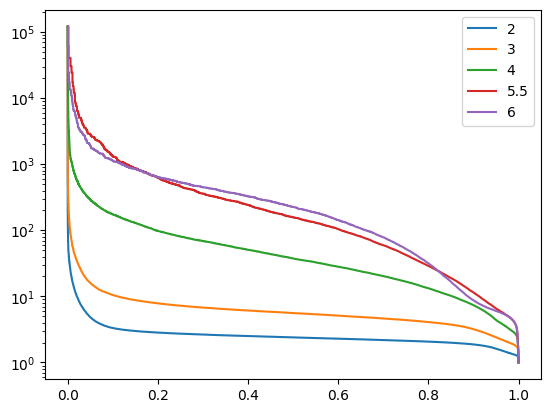

In [64]:
for m in [2, 3, 4, 5.5, 6]:
    something = x_vals_all[np.product(x_vals_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    #plt.plot(tpr_all_BCE_50, fpr_all_BCE_50)
    plt.legend()
    plt.yscale("log")

In [83]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(182564, 2)

In [84]:
np.shape(something[:,4:6])

(182564, 2)

In [66]:
preds_all_BCE_100 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

175/175 [==============================] - 0s 679us/step


Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

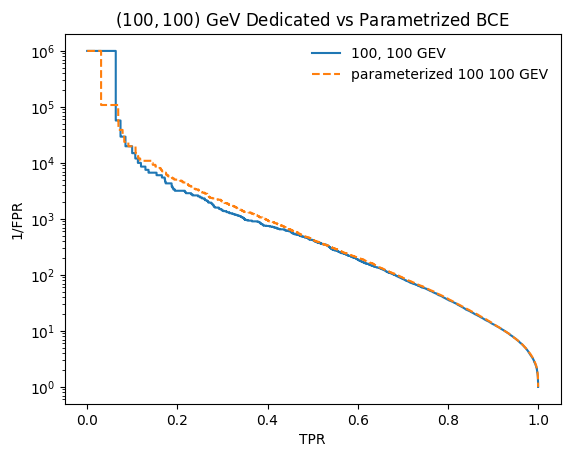

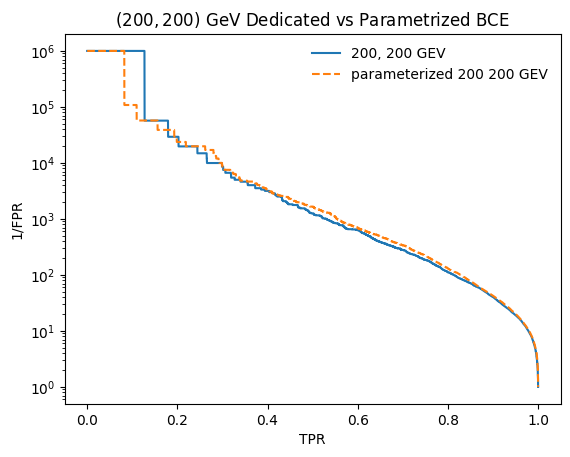

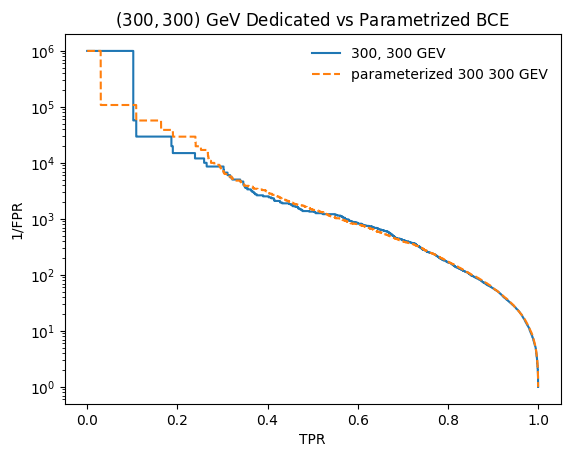

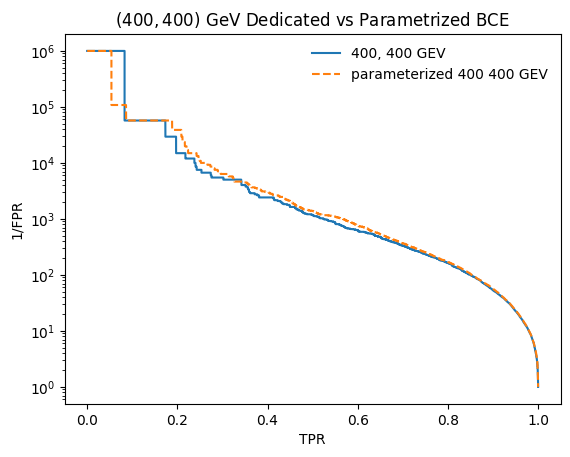

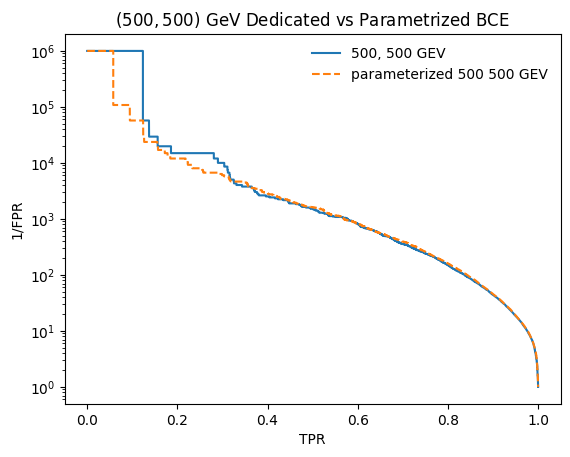

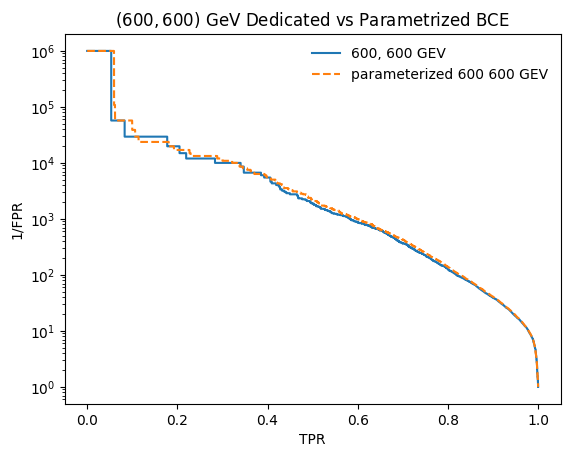

In [85]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

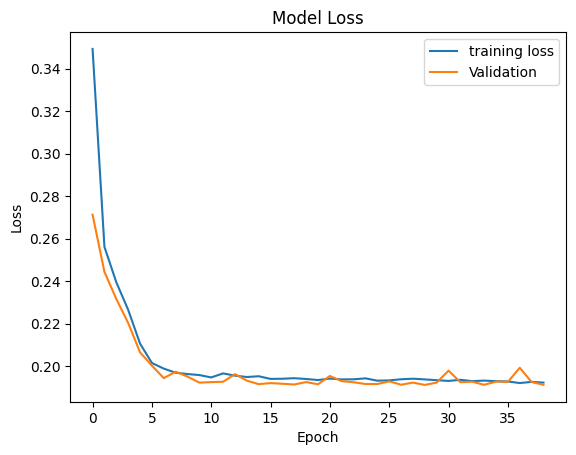

In [153]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


In [121]:
y_val_all_pred = model_all_BCE.predict(X_val_all)
auc_all = roc_auc_score(Y_val_all, y_val_all_pred)

print("AUC:", auc_all)

425773/425773 [==============================] - 301s 707us/step
AUC: 0.98044191324073


In [129]:
preds_all_BCE_51 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[5,1],axis=1)==1],batch_size=1000)
auc_all_51 = roc_auc_score(y_vals_all[np.product(x_vals_all[:,4:6]==[5,1],axis=1)==1], preds_all_BCE_51)

print("AUC:", auc_all_51)

180/180 [==============================] - 0s 856us/step
AUC: 0.97088308745336


In [ ]:
y_val_all_pred = model_all_BCE.predict(X_val_all[:,4:6]==[5,1])
auc_all = roc_auc_score(Y_val_all, y_val_all_pred)

print("AUC:", auc_all)

In [9]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all_fixed",x_vals_all)
    np.save("y_vals_all_fixed",y_vals_all)

In [2]:
x_vals_all = np.load("x_vals_all_fixed.npy")
y_vals_all = np.load("y_vals_all_fixed.npy")

In [77]:
x[0,0]

array([[-1.51676489, -0.61369051, -1.38971593,  0.29774299],
       [-1.36743797, -1.69854625,  0.49237384,  1.2508466 ],
       [-0.91169568, -1.71429933,  1.16183161,  0.35001884],
       ...,
       [-0.96736856, -1.48238533,  1.25627805, -0.47600159],
       [-1.3598598 , -1.72354998,  1.79984225,  1.20196723],
       [-1.42887276, -1.6890858 ,  0.89163538,  0.58092406]])

In [11]:
x_vals_all

array([[-1.51676489, -0.61369051, -1.38971593,  0.29774299,  0.5       ,
         0.5       ],
       [-1.36743797, -1.69854625,  0.49237384,  1.2508466 ,  0.5       ,
         0.5       ],
       [-0.91169568, -1.71429933,  1.16183161,  0.35001884,  0.5       ,
         0.5       ],
       ...,
       [ 1.67050639, -1.47882044, -1.74258998, -0.4207081 ,  6.        ,
         6.        ],
       [ 1.35240368, -1.31499431, -1.59333439, -2.25761048,  6.        ,
         6.        ],
       [-0.43435266,  0.80463752, -0.29540807, -1.79924529,  6.        ,
         6.        ]])

In [7]:
np.shape(x_vals_all)

(27249420, 6)

In [12]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [130]:
Y_val_all

array([1., 1., 1., ..., 1., 1., 0.])

In [13]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh. Use `wandb login --relogin` to force relogin


In [14]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

2023-11-28 16:48:10.223568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 16:48:11.312493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0


In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
with tf.device('/GPU:0'):
    myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/1000
  35/2662 [..............................] - ETA: 3s - loss: 0.3881 - accuracy: 0.8266     

2023-11-28 16:48:14.742043: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2631/2662 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9236INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 9s 3ms/step - loss: 0.1939 - accuracy: 0.9237 - val_loss: 0.1753 - val_accuracy: 0.9313
Epoch 2/1000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9324INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1723 - accuracy: 0.9324 - val_loss: 0.1731 - val_accuracy: 0.9320
Epoch 3/1000
2634/2662 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9330INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 3ms/step - loss: 0.1705 - accuracy: 0.9330 - val_loss: 0.1701 - val_accuracy: 0.9331
Epoch 4/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1697 - accuracy: 0.9332 - val_loss: 0.1701 - val_accuracy: 0.9330
Epoch 5/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1693 - accuracy: 0.9334 - val_loss: 0.1708 - val_accuracy: 0.9327
Epoch 6/1000
2651/2662 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 3ms/step - loss: 0.1690 - accuracy: 0.9335 - val_loss: 0.1698 - val_accuracy: 0.9332
Epoch 7/1000
2643/2662 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9336INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1687 - accuracy: 0.9336 - val_loss: 0.1689 - val_accuracy: 0.9335
Epoch 8/1000
2644/2662 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9337INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 3ms/step - loss: 0.1686 - accuracy: 0.9337 - val_loss: 0.1685 - val_accuracy: 0.9337
Epoch 9/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1684 - accuracy: 0.9338 - val_loss: 0.1691 - val_accuracy: 0.9333
Epoch 10/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1682 - accuracy: 0.9338 - val_loss: 0.1693 - val_accuracy: 0.9333
Epoch 11/1000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9338INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 3ms/step - loss: 0.1681 - accuracy: 0.9338 - val_loss: 0.1680 - val_accuracy: 0.9338
Epoch 12/1000
2630/2662 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9338INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231128_164804-l4yjh0h4/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1680 - accuracy: 0.9338 - val_loss: 0.1676 - val_accuracy: 0.9340
Epoch 13/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1679 - accuracy: 0.9339 - val_loss: 0.1680 - val_accuracy: 0.9338
Epoch 14/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1678 - accuracy: 0.9339 - val_loss: 0.1695 - val_accuracy: 0.9332
Epoch 15/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1678 - accuracy: 0.9339 - val_loss: 0.1683 - val_accuracy: 0.9337
Epoch 16/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1677 - accuracy: 0.9340 - val_loss: 0.1678 - val_accuracy: 0.9340
Epoch 17/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1676 - accuracy: 0.9340 - val_loss: 0.1679 - val_accuracy: 0.9338


In [17]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇█████████████
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▅▅▆▇▇▆▆▇█▇▆▇█▇
val_loss,█▆▃▃▄▃▂▂▂▂▁▁▁▃▂▁▁
accuracy,0.93403
best_epoch,11
best_val_loss,0.16765
epoch,16
loss,0.16763
val_accuracy,0.93383


In [24]:
#model_all.save("model_all_BCE")
#model_all.save("model_all_MSE_Fixed_3_512")

INFO:tensorflow:Assets written to: model_all_BCE/assets


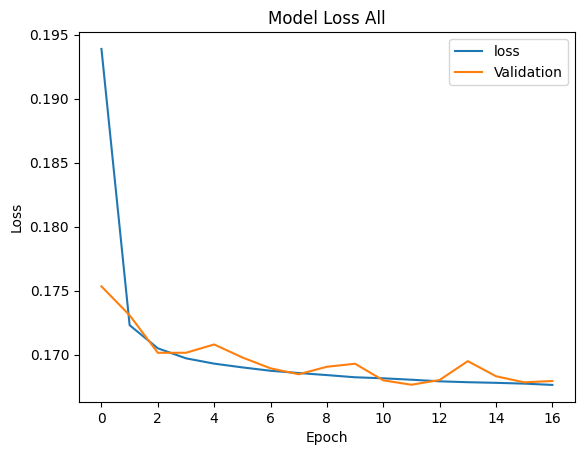

In [18]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [129]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

100/100 [==============================] - 0s 690us/step


In [120]:
model_all = tf.keras.models.load_model("model_all_BCE")

In [130]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 675us/step


/tmp/ipykernel_808700/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_808700/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

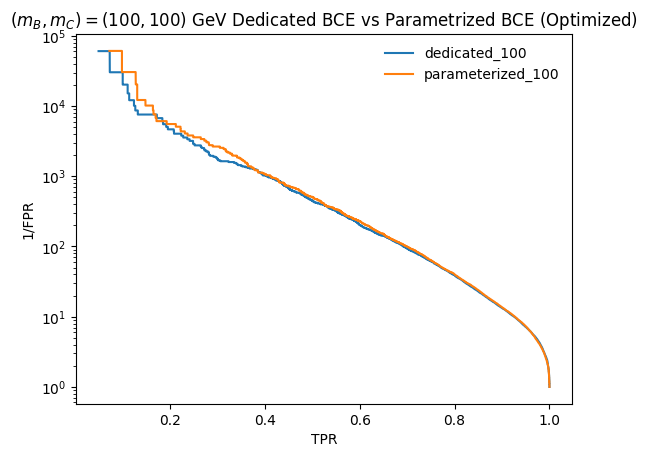

In [131]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [82]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [9]:
model_all = tf.keras.models.load_model("model_all_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-11-25 17:11:48.217370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 17:11:49.195751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25231 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [32]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(2)
            model32 = createSimpleModel(3)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

0.5 0.5 0.5491803 9.021994
0.5 1 1.1752597 8.985956
0.5 1.5 1.7168411 9.784072
0.5 2 2.2314804 10.173839
0.5 2.5 2.5977345 2.5790203
0.5 3 3.0950694 3.0946405
0.5 3.5 0.5241808 3.4972951
0.5 4 0.5190985 3.983502
0.5 4.5 0.5346133 4.481165
0.5 5 0.53078973 5.008945
0.5 5.5 0.5400266 5.4809976
0.5 6 0.5520322 5.982666
1 0.5 1.1909544 9.069262
1 1 1.0596074 8.468231
1 1.5 1.6835192 8.926991
1 2 2.199494 9.718389
1 2.5 2.56747 2.5462327
1 3 1.0463839 3.010136
1 3.5 1.0547118 3.5140574
1 4 1.0617639 4.003348
1 4.5 1.0545555 4.5172358
1 5 1.0603002 5.007464
1 5.5 1.0624789 5.5290637
1 6 1.0638912 5.9943805
1.5 0.5 1.7238075 9.792358
1.5 1 1.6863937 8.924274
1.5 1.5 1.5503311 1.512562
1.5 2 1.5417204 2.0125449
1.5 2.5 1.5446966 2.5312426
1.5 3 1.5453459 3.013283
1.5 3.5 1.5218555 3.5464509
1.5 4 1.5523617 4.010661
1.5 4.5 1.5658842 4.5100675
1.5 5 1.5637821 5.013837
1.5 5.5 1.5637577 5.5042734
1.5 6 1.5725037 6.012097
2 0.5 2.24231 10.157302
2 1 2.2035065 9.717022
2 1.5 1.5262563 2.0145059
2 

In [33]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.5491803 9.021994 ]
[0.5 1. ] [1.1752597 8.985956 ]
[0.5 1.5] [1.7168411 9.784072 ]
[0.5 2. ] [ 2.2314804 10.173839 ]
[0.5 2.5] [2.5977345 2.5790203]
[0.5 3. ] [3.0950694 3.0946405]
[1.  0.5] [1.1909544 9.069262 ]
[1. 1.] [1.0596074 8.468231 ]
[1.  1.5] [1.6835192 8.926991 ]
[1. 2.] [2.199494 9.718389]
[1.  2.5] [2.56747   2.5462327]
[1.5 0.5] [1.7238075 9.792358 ]
[1.5 1. ] [1.6863937 8.924274 ]
[2.  0.5] [ 2.24231  10.157302]
[2. 1.] [2.2035065 9.717022 ]
[2.5 0.5] [2.6047301 2.5865421]
[2.5 1. ] [2.5693932 2.5542233]
[3.  0.5] [3.0988517 3.0894363]
[3.5 0.5] [3.5923848 3.5996833]
[5.5 0.5] [0.22287026 5.527169  ]
[6.  0.5] [0.18784916 6.0023403 ]
found both: 0.8541666666666666
found one: 0.1111111111111111
found none: 0.034722222222222224


In [147]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [38]:
m1_list == np.array(mass_range[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

2 4.5 0.001
30338.0 91014.0 30 0.0009888588568791614
3 3 2.5081894 4.6991296
96/96 [==============================] - 0s 637us/step
2 4.5 0.0012742749857031334
30338.0 91014.0 38 0.0012525545520469378


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.4392488 4.744383
96/96 [==============================] - 0s 599us/step
2 4.5 0.001623776739188721
30338.0 91014.0 49 0.0016151361329026304


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5157676 4.612597
96/96 [==============================] - 0s 620us/step
2 4.5 0.00206913808111479
30338.0 91014.0 62 0.002043641637550267


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7599285 4.3567386
96/96 [==============================] - 0s 618us/step
2 4.5 0.0026366508987303583


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338.0 91014.0 79 0.002603994989781792
3 3 1.7816566 4.3883333
96/96 [==============================] - 0s 692us/step
2 4.5 0.003359818286283781
30338.0 91014.0 101 0.003329158151493177


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.4517499 4.284931
96/96 [==============================] - 0s 626us/step
2 4.5 0.004281332398719396
30338.0 91014.0 129 0.004252093084580394


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5490105 4.640059
96/96 [==============================] - 0s 616us/step
2 4.5 0.00545559478116852
30338.0 91014.0 165 0.005438723712835388


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5520835 4.7273316
96/96 [==============================] - 0s 608us/step
2 4.5 0.0069519279617756054
30338.0 91014.0 210 0.00692201199815413


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7569467 4.354641
96/96 [==============================] - 0s 616us/step
2 4.5 0.008858667904100823
30338.0 91014.0 268 0.008833805788120508


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.6247861 4.6224136
96/96 [==============================] - 0s 633us/step
2 4.5 0.011288378916846888
30338.0 91014.0 342 0.011272990968422441


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.016388 3.0365188
96/96 [==============================] - 0s 628us/step
2 4.5 0.01438449888287663
30338.0 91014.0 436 0.014371415386643813


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7694539 4.374386
96/96 [==============================] - 0s 652us/step
2 4.5 0.018329807108324356
30338.0 91014.0 556 0.01832685081416046


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9922736 3.0087476
96/96 [==============================] - 0s 624us/step
2 4.5 0.023357214690901212
30338.0 91014.0 708 0.02333706902234821


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0022745 3.0318778
96/96 [==============================] - 0s 623us/step
2 4.5 0.029763514416313176
30338.0 91014.0 902 0.02973168963016679


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.018773 3.0460777
96/96 [==============================] - 0s 636us/step
2 4.5 0.0379269019073225
30338.0 91014.0 1150 0.03790625618036786


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0151205 3.0337098
96/96 [==============================] - 0s 625us/step
2 4.5 0.04832930238571752
30338.0 91014.0 1466 0.048322236139495024


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0092762 3.0362751
96/96 [==============================] - 0s 601us/step
2 4.5 0.06158482110660261
30338.0 91014.0 1868 0.06157294482167579


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9817054 3.0279546
96/96 [==============================] - 0s 648us/step
2 4.5 0.07847599703514611
30338.0 91014.0 2380 0.07844946931241348


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9987402 3.0196197
96/96 [==============================] - 0s 652us/step
2 4.5 0.1
30338.0 91014.0 3033 0.09997363043048323


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9871018 3.046082
96/96 [==============================] - 0s 648us/step


/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3305553573.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


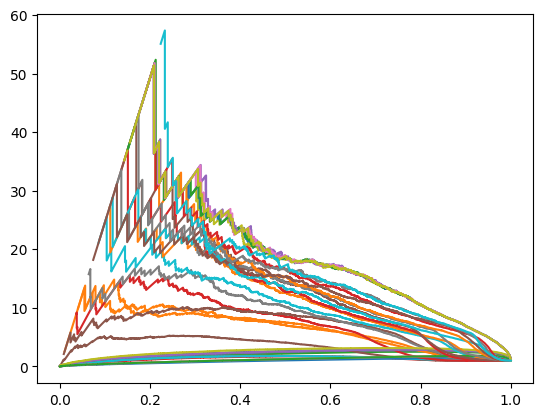

In [65]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

epsilon = 1e-6

w1 = 2
w2 = 4.5

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR - sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3

    test_set_back = int(len(x[0,0])*0.5)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = int(len(x[0,0])*0.25)
    test_set_sig = int(len(x[m1,m2])*0.5)
    mu = sigfrac

    N = 0.25 * len(x[0,0])
    signal = x[m1,m2][test_set_sig:test_set_sig+int(mu*N)]
    tot = train_set_reference
    x_vals_ = np.concatenate([x[0,0][test_set_back:],signal])
    y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(signal))])

    print(N,len(x[0,0])-N,len(signal),len(x[m1,m2][0:int(mu*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)

    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1.append([np.max(tpr/np.sqrt(fpr+epsilon))])
    msic2.append([np.max(tpr2/np.sqrt(fpr2+epsilon))])

In [68]:
np.shape(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*N)])
int(sig_frac*N)

3033

2 4.5 0.001
30338 91014 30 0.0009888588568791614
3 3 2.4662473 4.7192554
119/119 [==============================] - 0s 614us/step
2 4.5 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.4253135 4.734296
119/119 [==============================] - 0s 602us/step
2 4.5 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5046651 4.6367645
119/119 [==============================] - 0s 664us/step
2 4.5 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5571141 4.6770105
119/119 [==============================] - 0s 613us/step
2 4.5 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5326104 4.6172266
119/119 [==============================] - 0s 630us/step
2 4.5 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5602143 4.687698
119/119 [==============================] - 0s 596us/step
2 4.5 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5518842 4.6065445
119/119 [==============================] - 0s 655us/step
2 4.5 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5518816 4.701306
119/119 [==============================] - 0s 625us/step
2 4.5 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7451775 4.344273
119/119 [==============================] - 0s 630us/step
2 4.5 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.6185248 4.6940794
119/119 [==============================] - 0s 670us/step
2 4.5 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.6528566 4.686688
119/119 [==============================] - 0s 654us/step
2 4.5 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.010575 3.0324244
119/119 [==============================] - 0s 603us/step
2 4.5 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9977677 3.0062213
119/119 [==============================] - 0s 631us/step
2 4.5 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9985826 3.021707
119/119 [==============================] - 0s 622us/step
2 4.5 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9989214 3.0632825
119/119 [==============================] - 0s 636us/step
2 4.5 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0051293 3.0559018
119/119 [==============================] - 0s 616us/step
2 4.5 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9740152 3.0362253
119/119 [==============================] - 0s 621us/step
2 4.5 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0171356 3.0317733
119/119 [==============================] - 0s 645us/step
2 4.5 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0112484 3.0774279
119/119 [==============================] - 0s 621us/step
2 4.5 0.1
30338 91014 3033 0.09997363043048323


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.994158 3.0497146
119/119 [==============================] - 0s 631us/step


/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/4266338170.py:93: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


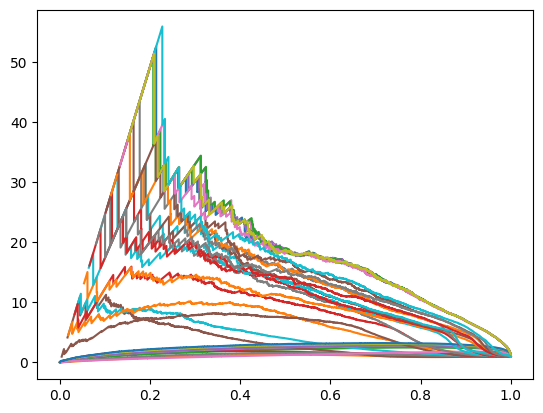

In [32]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

epsilon = 1e-6

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)

# initial_learning_rate = 0.05 #placeholder till callback

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=30*3, decay_rate=0.7, staircase=True
# )

w1 = 2
w2 = 4.5

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.- hidden_layer_1 + epsilon)
    LLR_xs = 1. + sigfrac*LLR - sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3

    test_set_back = int(len(x[0,0])*0.50)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = int(len(x[0,0])* 0.25)
    test_set_sig = int(len(x[0,0])*0.50)
    sig_frac = sigfrac

    tot = train_set_reference
    x_vals_ = np.concatenate([x[0,0][test_set_background:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
    y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

    print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)

    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
    msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])

In [58]:
np.shape(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)])

(3033, 4)

In [49]:
train_set_reference * .006

182.028

(0.0, 700.0)

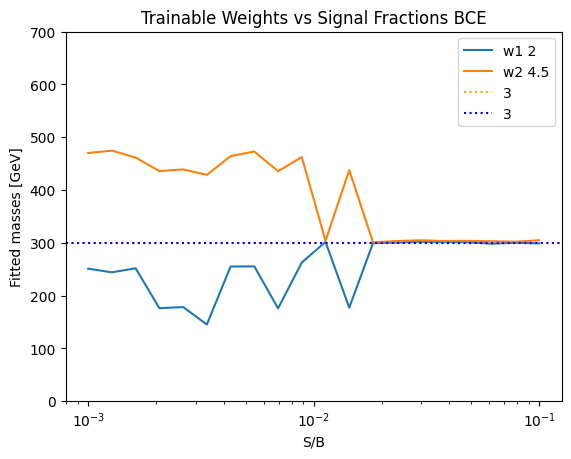

In [69]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

(0.0, 700.0)

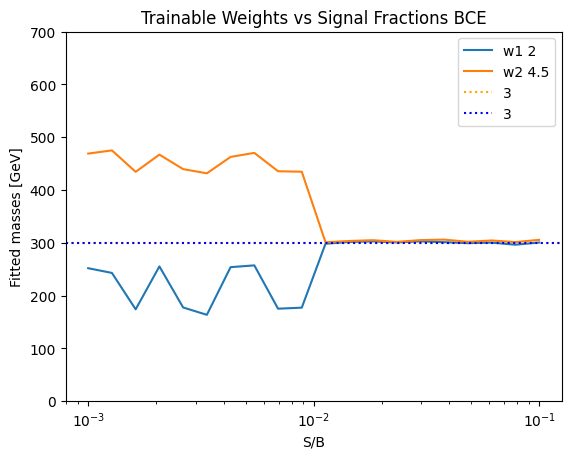

In [20]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

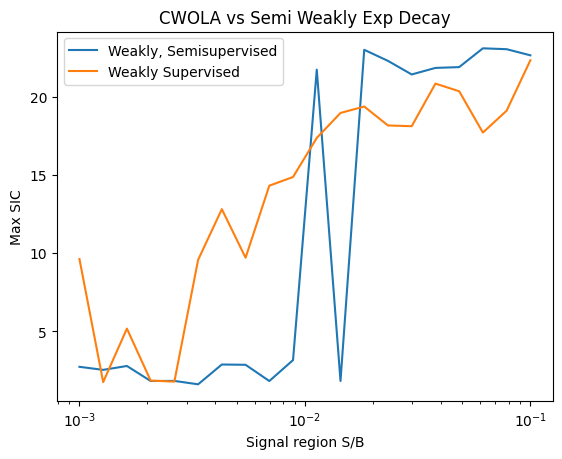

In [70]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

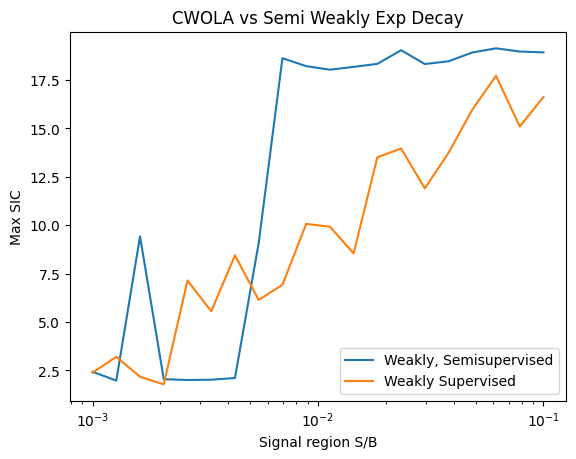

In [283]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

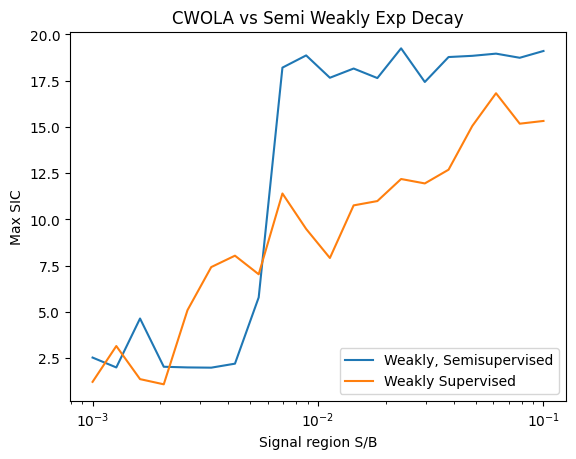

In [266]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

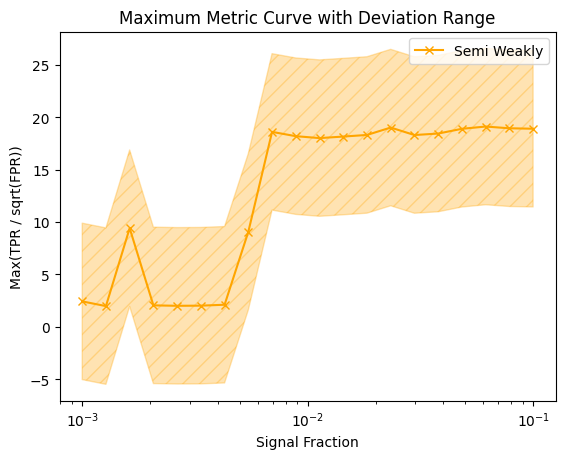

In [286]:
signal_fraction_values = sigspace
max_metric_list = max_sics

max_metric_array = np.array(max_metric_list)
metric_deviations = np.std(max_sics)

lower_bound = max_metric_array - metric_deviations
upper_bound = max_metric_array + metric_deviations

plt.plot(signal_fraction_values, max_metric_array, marker = "x", label='Semi Weakly', color='orange')

plt.fill_between(signal_fraction_values, lower_bound, upper_bound, color='orange', alpha=0.3, hatch = "//")

plt.xlabel('Signal Fraction')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title('Maximum Metric Curve with Deviation Range')
plt.xscale("log")
plt.legend()
plt.show()

In [285]:
max_sics = []
for i in msic1:
    max_sics.append(i[0])
    
max_sics

[2.4309323360979778,
 1.9804437133281951,
 9.421332387314994,
 2.051201006597298,
 2.009204898633507,
 2.02313365126546,
 2.1110204067887253,
 9.0787128610043,
 18.617907388339702,
 18.207081164332568,
 18.023868869446044,
 18.17042730278634,
 18.324231254694652,
 19.030078895568437,
 18.316985736126632,
 18.458165217929952,
 18.91151142581412,
 19.127420923223607,
 18.961641468558412,
 18.91889153540958]

2 4.5 0.001
30338 91014 30 0.0009888588568791614
3 3 1.7520146 4.319321
96/96 [==============================] - 0s 732us/step
2 4.5 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.4472942 4.7456093
96/96 [==============================] - 0s 633us/step
2 4.5 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7725015 4.3642545
96/96 [==============================] - 0s 628us/step
2 4.5 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5487056 4.686002
96/96 [==============================] - 0s 622us/step
2 4.5 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5173976 4.6371126
96/96 [==============================] - 0s 599us/step
2 4.5 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.6382068 4.3192306
96/96 [==============================] - 0s 602us/step
2 4.5 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.5538242 4.6064625
96/96 [==============================] - 0s 618us/step
2 4.5 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.6211342 4.322792
96/96 [==============================] - 0s 626us/step
2 4.5 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 1.7698015 4.3530145
96/96 [==============================] - 0s 625us/step
2 4.5 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.6486802 4.6931415
96/96 [==============================] - 0s 622us/step
2 4.5 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0299165 3.0486825
96/96 [==============================] - 0s 596us/step
2 4.5 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0018926 3.02291
96/96 [==============================] - 0s 642us/step
2 4.5 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0338979 3.0498886
96/96 [==============================] - 0s 604us/step
2 4.5 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9991047 3.0252666
96/96 [==============================] - 0s 631us/step
2 4.5 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9958847 3.0129712
96/96 [==============================] - 0s 638us/step
2 4.5 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 3.0126252 3.0252125
96/96 [==============================] - 0s 606us/step
2 4.5 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9984581 3.0228696
96/96 [==============================] - 0s 608us/step
2 4.5 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.983153 2.999464
96/96 [==============================] - 0s 621us/step
2 4.5 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9862676 3.033637
96/96 [==============================] - 0s 639us/step
2 4.5 0.1
30338 91014 3033 0.09997363043048323


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


3 3 2.9706016 3.0266516
96/96 [==============================] - 0s 612us/step


/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:104: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_1808730/3523400360.py:105: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


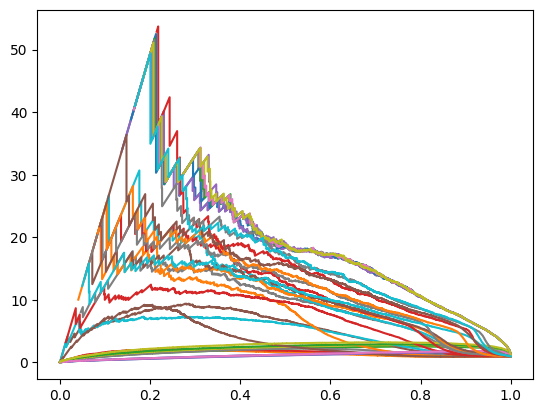

In [72]:
#fixed signal mass pair, different initializations of weights

msic1_runs = []
msic2_runs = []

num_runs = 1

for _ in range(num_runs):
    
    xx = []
    yy = []
    zz = []
    ww = []
    
    msic1 = []
    msic2 = []

    epsilon = 1e-6

    # w1 = round(random.uniform(0.5, 6.0),3)
    # w2 = round(random.uniform(0.5, 6.0),3)

    # w1 = 3.241
    # w2 = 3.649
    
    w1 = 2
    w2 = 4.5

#     initial_learning_rate = 0.05 #placeholder till callback

#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, decay_steps=30*3, decay_rate=0.7, staircase=True
#     )

    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR - sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        backtoprob = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = backtoprob)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 3

        test_set_back = int(len(x[0,0])*0.5)
        train_set_reference = int(len(x[0,0])*0.25)
        train_set_data = len(x[0,0]) - test_set_back - train_set_reference
        test_set_sig = int(len(x[m1,m2])*0.5)
        sig_frac = sigfrac

        tot = train_set_reference
        x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
        y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

        print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
        msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)

(0.0, 700.0)

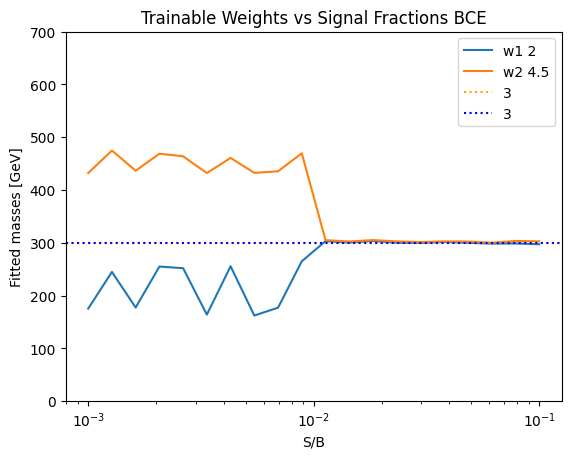

In [73]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

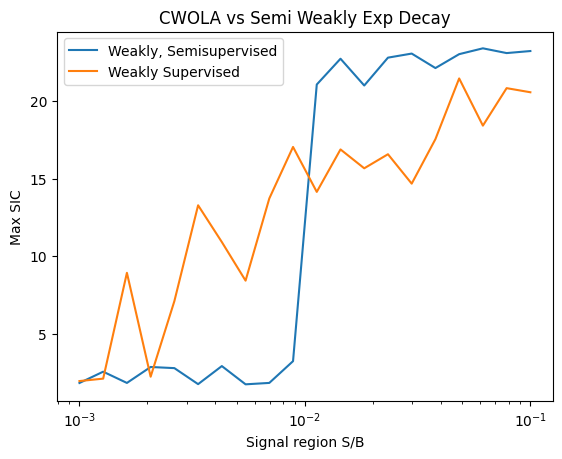

In [74]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

In [159]:
sig_list = np.logspace(-3,-1,20)

Text(0, 0.5, 'Avg Max SIC')

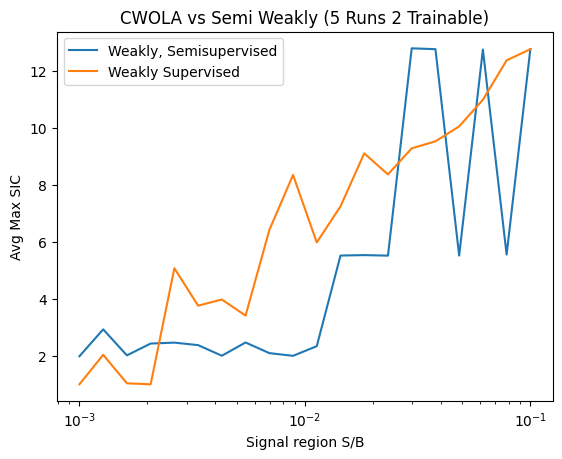

In [279]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (5 Runs 2 Trainable)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [172]:
np.shape(msic1_runs)

(5, 20, 1)

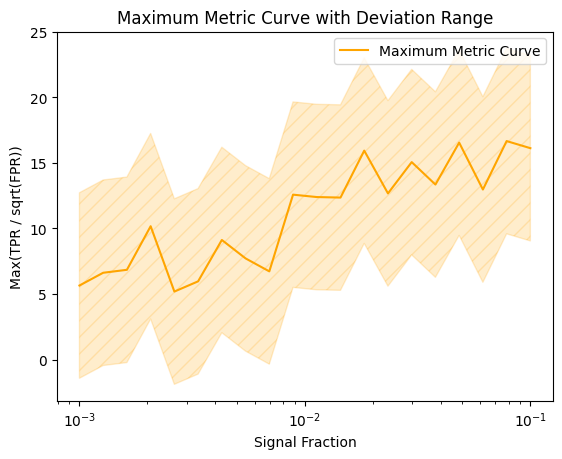

In [242]:
signal_fraction_values = sigspace
max_metric_list = max_sics

max_metric_array = np.array(max_metric_list)
metric_deviations = np.std(msic1_runs)

lower_bound = max_metric_array - metric_deviations
upper_bound = max_metric_array + metric_deviations

plt.plot(signal_fraction_values, max_metric_array, label='Maximum Metric Curve', color='orange')

plt.fill_between(signal_fraction_values, lower_bound, upper_bound, color='orange', alpha=0.2, hatch = "//")

plt.xlabel('Signal Fraction')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title('Maximum Metric Curve with Deviation Range')
plt.xscale("log")
plt.legend()
plt.show()

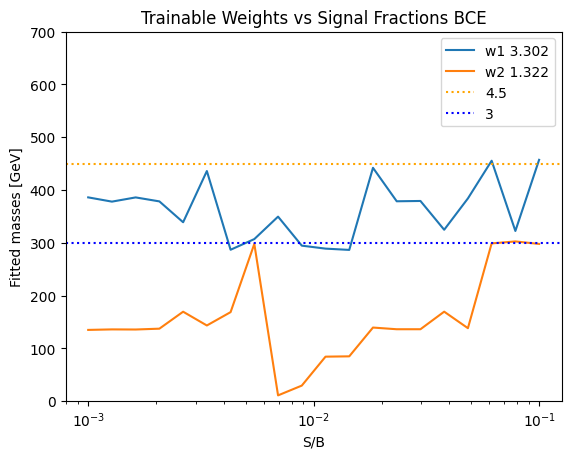

In [107]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'Max SIC')

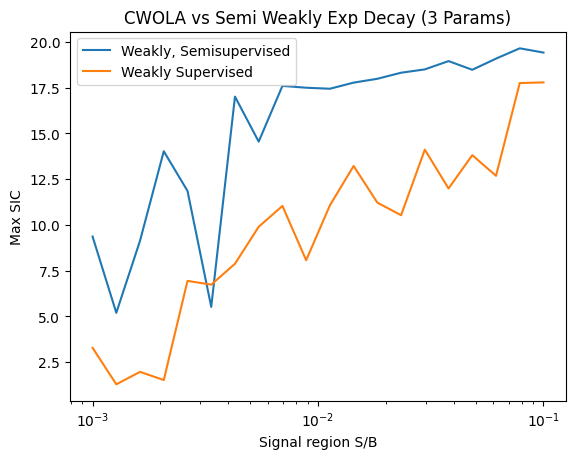

In [187]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay (3 Params)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Fitted S/B')

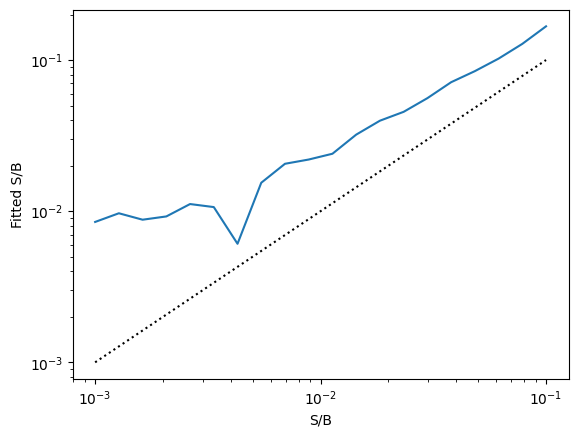

In [19]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'Max SIC')

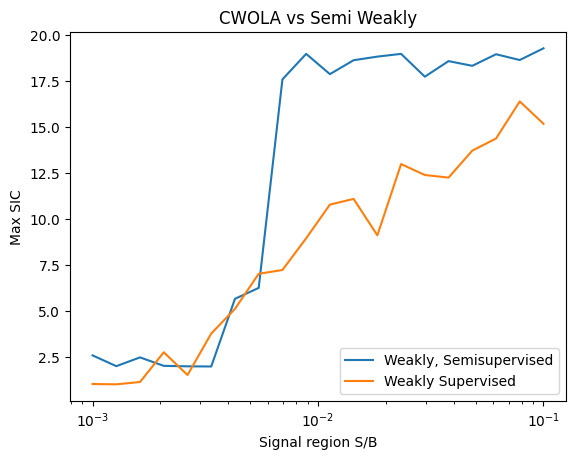

In [11]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

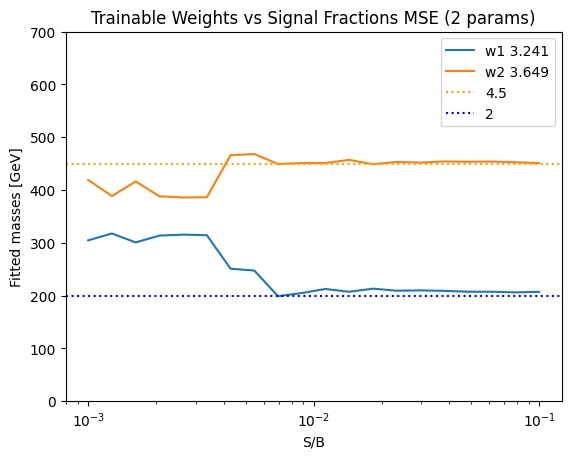

In [21]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

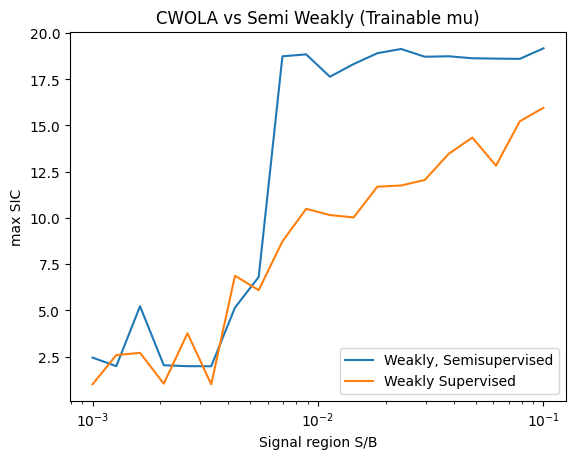

In [18]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'Fitted S/B')

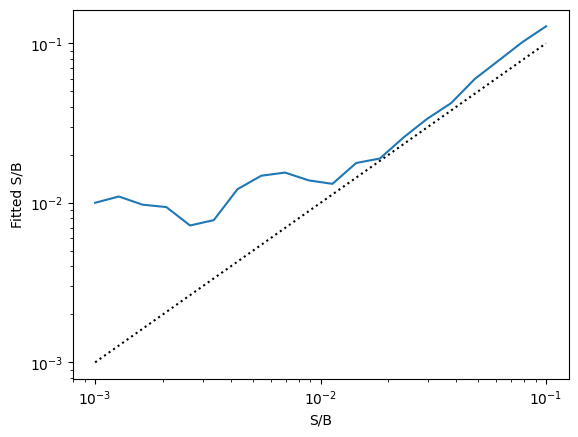

In [15]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'max SIC')

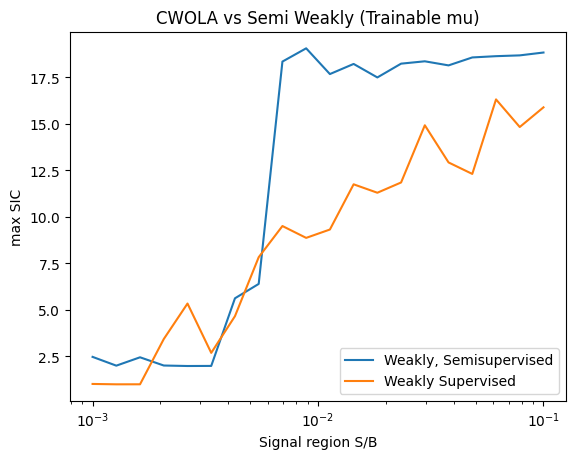

In [22]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

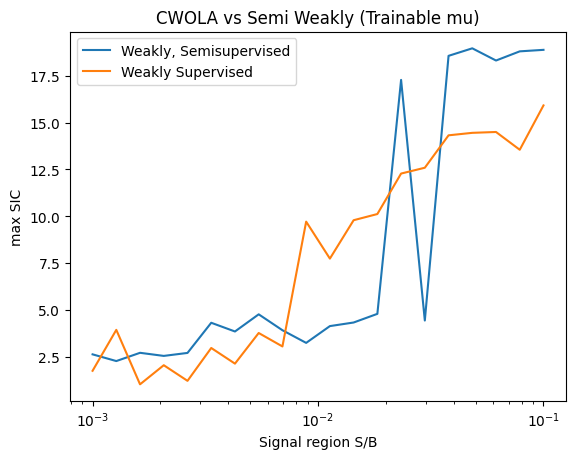

In [56]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

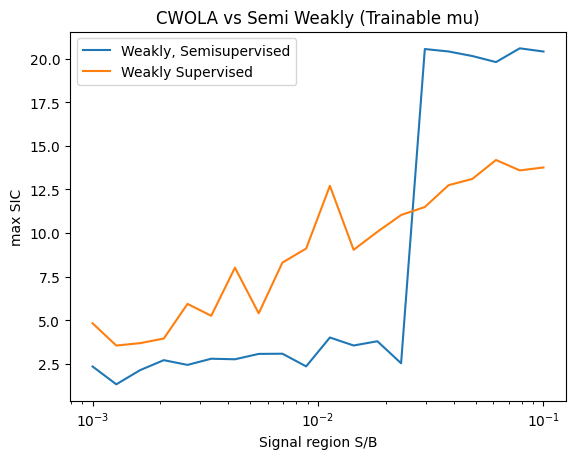

In [115]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

1.862 4.478 0.001
30338 91014 30 0.0009888588568791614
1 5.5 0.95817214 4.9984055
93/93 [==============================] - 0s 861us/step
1.862 4.478 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.7706703 4.4122667
93/93 [==============================] - 0s 907us/step
1.862 4.478 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 2.5470147 4.6349573
93/93 [==============================] - 0s 874us/step
1.862 4.478 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0224239 5.7091227
93/93 [==============================] - 0s 880us/step
1.862 4.478 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 2.593442 4.609196
93/93 [==============================] - 0s 885us/step
1.862 4.478 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0196285 5.4372716
93/93 [==============================] - 0s 882us/step
1.862 4.478 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0268061 5.4808564
93/93 [==============================] - 0s 881us/step
1.862 4.478 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0120088 5.703663
93/93 [==============================] - 0s 848us/step
1.862 4.478 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.7402335 4.391758
93/93 [==============================] - 0s 1ms/step
1.862 4.478 0.008858667904100823


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 268 0.008833805788120508
1 5.5 1.0401204 5.526288
93/93 [==============================] - 0s 883us/step
1.862 4.478 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0497336 5.4826636
93/93 [==============================] - 0s 983us/step
1.862 4.478 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0357448 5.568733
93/93 [==============================] - 0s 788us/step
1.862 4.478 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 2.640235 4.8411803
93/93 [==============================] - 0s 879us/step
1.862 4.478 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0421386 5.5365105
93/93 [==============================] - 0s 896us/step
1.862 4.478 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 2.5896392 4.8727393
93/93 [==============================] - 0s 903us/step
1.862 4.478 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.035715 5.5099607
93/93 [==============================] - 0s 814us/step
1.862 4.478 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.042654 5.529805
93/93 [==============================] - 0s 856us/step
1.862 4.478 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0446701 5.5143375
93/93 [==============================] - 0s 860us/step
1.862 4.478 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0419567 5.5258055
93/93 [==============================] - 0s 884us/step
1.862 4.478 0.1
30338 91014 3033 0.09997363043048323


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 1.0505395 5.535122
93/93 [==============================] - 0s 877us/step
5.464 1.97 0.001
30338 91014 30 0.0009888588568791614


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.966238 2.3347642
93/93 [==============================] - 0s 846us/step
5.464 1.97 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.7688155 2.3691053
93/93 [==============================] - 0s 851us/step
5.464 1.97 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.007018 1.9879795
93/93 [==============================] - 0s 932us/step
5.464 1.97 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.14179 2.4986012
93/93 [==============================] - 0s 885us/step
5.464 1.97 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.2050276 1.334489
93/93 [==============================] - 0s 859us/step
5.464 1.97 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.8877087 1.9859242
93/93 [==============================] - 0s 863us/step
5.464 1.97 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.6268682 0.96819943
93/93 [==============================] - 0s 916us/step
5.464 1.97 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.0330963 2.4989257
93/93 [==============================] - 0s 951us/step
5.464 1.97 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.6481886 2.56419
93/93 [==============================] - 0s 928us/step
5.464 1.97 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.6891503 2.5487437
93/93 [==============================] - 0s 908us/step
5.464 1.97 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.739211 2.5381567
93/93 [==============================] - 0s 904us/step
5.464 1.97 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5827746 0.97974205
93/93 [==============================] - 0s 912us/step
5.464 1.97 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.7709413 2.5914862
93/93 [==============================] - 0s 902us/step
5.464 1.97 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5564046 0.98346144
93/93 [==============================] - 0s 962us/step
5.464 1.97 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5430226 0.98067254
93/93 [==============================] - 0s 936us/step
5.464 1.97 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5067244 0.98345506
93/93 [==============================] - 0s 1ms/step
5.464 1.97 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.545113 0.9863032
93/93 [==============================] - 0s 1ms/step
5.464 1.97 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.502479 0.9890428
93/93 [==============================] - 0s 982us/step
5.464 1.97 0.07847599703514611


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 2380 0.07844946931241348
1 5.5 5.517337 0.98875356
93/93 [==============================] - 0s 925us/step
5.464 1.97 0.1
30338 91014 3033 0.09997363043048323


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5341597 0.99422586
93/93 [==============================] - 0s 888us/step
5.456 2.553 0.001
30338 91014 30 0.0009888588568791614


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.960167 2.3348944
93/93 [==============================] - 0s 757us/step
5.456 2.553 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.0090613 2.3959453
93/93 [==============================] - 0s 908us/step
5.456 2.553 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.4991217 0.9848797
93/93 [==============================] - 0s 875us/step
5.456 2.553 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.9557467 3.0673282
93/93 [==============================] - 0s 933us/step
5.456 2.553 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.578217 2.5197732
93/93 [==============================] - 0s 896us/step
5.456 2.553 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.645894 2.5379622
93/93 [==============================] - 0s 1ms/step
5.456 2.553 0.004281332398719396


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
1 5.5 5.924153 3.06696
93/93 [==============================] - 0s 869us/step
5.456 2.553 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.693335 2.5284705
93/93 [==============================] - 0s 818us/step
5.456 2.553 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.528946 2.6688273
93/93 [==============================] - 0s 888us/step
5.456 2.553 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.6663465 2.5493374
93/93 [==============================] - 0s 903us/step
5.456 2.553 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 6.039379 2.5284295
93/93 [==============================] - 0s 843us/step
5.456 2.553 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.7680593 2.5461361
93/93 [==============================] - 0s 902us/step
5.456 2.553 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.7710996 2.5917702
93/93 [==============================] - 0s 887us/step
5.456 2.553 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.822142 2.563165
93/93 [==============================] - 0s 881us/step
5.456 2.553 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.909671 2.5466647
93/93 [==============================] - 0s 914us/step
5.456 2.553 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.841648 2.5786989
93/93 [==============================] - 0s 858us/step
5.456 2.553 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 4.914823 2.5497308
93/93 [==============================] - 0s 848us/step
5.456 2.553 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.056252 2.5350852
93/93 [==============================] - 0s 882us/step
5.456 2.553 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.611072 2.6100984
93/93 [==============================] - 0s 1ms/step
5.456 2.553 0.1


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
1 5.5 5.556456 2.8609796
93/93 [==============================] - 0s 909us/step
5.474 3.85 0.001
30338 91014 30 0.0009888588568791614


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2995477 3.9132395
93/93 [==============================] - 0s 1ms/step
5.474 3.85 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2761374 3.850521
93/93 [==============================] - 0s 856us/step
5.474 3.85 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.257254 3.814748
93/93 [==============================] - 0s 831us/step
5.474 3.85 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2598343 3.9127285
93/93 [==============================] - 0s 782us/step
5.474 3.85 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.4239116 3.8619092
93/93 [==============================] - 0s 852us/step
5.474 3.85 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2543054 3.8070374
93/93 [==============================] - 0s 731us/step
5.474 3.85 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2746277 3.8586369
93/93 [==============================] - 0s 871us/step
5.474 3.85 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5409737 3.7881348
93/93 [==============================] - 0s 886us/step
5.474 3.85 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.276294 3.8508132
93/93 [==============================] - 0s 838us/step
5.474 3.85 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2581396 3.8587515
93/93 [==============================] - 0s 858us/step
5.474 3.85 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.9734545 2.8792772
93/93 [==============================] - 0s 851us/step
5.474 3.85 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.1545777 3.8620076
93/93 [==============================] - 0s 828us/step
5.474 3.85 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.26122 3.8555675
93/93 [==============================] - 0s 779us/step
5.474 3.85 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2723184 3.8224247
93/93 [==============================] - 0s 879us/step
5.474 3.85 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.4172754 3.784799
93/93 [==============================] - 0s 901us/step
5.474 3.85 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.2757316 3.8205705
93/93 [==============================] - 0s 826us/step
5.474 3.85 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.6220794 3.5266755
93/93 [==============================] - 0s 846us/step
5.474 3.85 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.779314 2.5321953
93/93 [==============================] - 0s 807us/step
5.474 3.85 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.4197397 3.8525608
93/93 [==============================] - 0s 868us/step
5.474 3.85 0.1
30338 91014 3033 0.09997363043048323


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 5.5697727 2.8176296
93/93 [==============================] - 0s 904us/step
0.512 2.512 0.001
30338 91014 30 0.0009888588568791614


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.017192874 3.6038117
93/93 [==============================] - 0s 907us/step
0.512 2.512 0.0012742749857031334
30338 91014 38 0.0012525545520469378


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.3574619 2.872854
93/93 [==============================] - 0s 998us/step
0.512 2.512 0.001623776739188721
30338 91014 49 0.0016151361329026304


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.35564992 2.7904189
93/93 [==============================] - 0s 854us/step
0.512 2.512 0.00206913808111479
30338 91014 62 0.002043641637550267


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.965205 2.862481
93/93 [==============================] - 0s 936us/step
0.512 2.512 0.0026366508987303583
30338 91014 79 0.002603994989781792


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.35763335 2.847309
93/93 [==============================] - 0s 883us/step
0.512 2.512 0.003359818286283781
30338 91014 101 0.003329158151493177


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.36098617 2.7899728
93/93 [==============================] - 0s 831us/step
0.512 2.512 0.004281332398719396
30338 91014 129 0.004252093084580394


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.05830846 2.5475543
93/93 [==============================] - 0s 892us/step
0.512 2.512 0.00545559478116852
30338 91014 165 0.005438723712835388


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.19136429 3.4756489
93/93 [==============================] - 0s 895us/step
0.512 2.512 0.0069519279617756054
30338 91014 210 0.00692201199815413


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.8821033 2.849443
93/93 [==============================] - 0s 893us/step
0.512 2.512 0.008858667904100823
30338 91014 268 0.008833805788120508


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 0.16998233 2.903493
93/93 [==============================] - 0s 885us/step
0.512 2.512 0.011288378916846888
30338 91014 342 0.011272990968422441


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.30065638 1.8824575
93/93 [==============================] - 0s 917us/step
0.512 2.512 0.01438449888287663
30338 91014 436 0.014371415386643813


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.09334863 2.5546703
93/93 [==============================] - 0s 926us/step
0.512 2.512 0.018329807108324356
30338 91014 556 0.01832685081416046


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.03403419 2.6076949
93/93 [==============================] - 0s 895us/step
0.512 2.512 0.023357214690901212
30338 91014 708 0.02333706902234821


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.05360108 2.5745242
93/93 [==============================] - 0s 917us/step
0.512 2.512 0.029763514416313176
30338 91014 902 0.02973168963016679


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.24276346 2.5535343
93/93 [==============================] - 0s 904us/step
0.512 2.512 0.0379269019073225
30338 91014 1150 0.03790625618036786


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.08887034 2.5808804
93/93 [==============================] - 0s 940us/step
0.512 2.512 0.04832930238571752
30338 91014 1466 0.048322236139495024


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.06068276 2.6046293
93/93 [==============================] - 0s 901us/step
0.512 2.512 0.06158482110660261
30338 91014 1868 0.06157294482167579


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.117162555 2.613295
93/93 [==============================] - 0s 873us/step
0.512 2.512 0.07847599703514611
30338 91014 2380 0.07844946931241348


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


1 5.5 -0.18951756 2.625006
93/93 [==============================] - 0s 1ms/step
0.512 2.512 0.1


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
1 5.5 1.0501081 5.533066
93/93 [==============================] - 0s 847us/step


/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:115: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_614398/3202497914.py:116: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


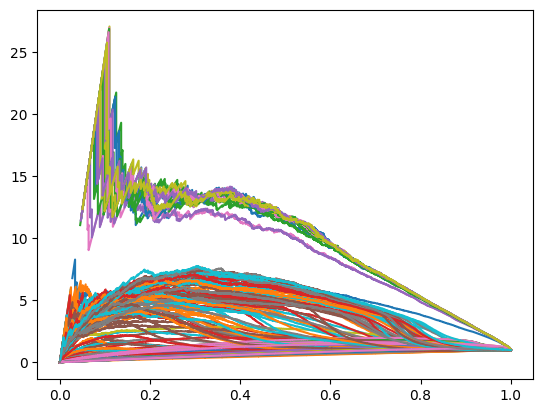

In [291]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

sic1_list_runs = []
sic2_list_runs = []

initial_weights_list_runs = []

initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.7, staircase=True
)

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    sic1 = []
    sic2 = []
    
    initial_weights_list_runs.append((w1, w2))
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR - sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        backtoprob = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = backtoprob)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

        m1 = 1
        m2 = 5.5

        test_set_back = int(len(x[0,0])*0.5)
        train_set_reference = int(len(x[0,0])*0.25)
        train_set_data = len(x[0,0]) - test_set_back - train_set_reference
        test_set_sig = int(len(x[m1,m2])*0.5)
        sig_frac = sigfrac

        tot = train_set_reference
        x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
        y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

        print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024,verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1.append(np.max(tpr/np.sqrt(fpr+0.0001)))
        msic2.append(np.max(tpr2/np.sqrt(fpr2+0.0001)))
        
        sic1.append((tpr/np.sqrt(fpr+0.0001)))
        sic2.append((tpr2/np.sqrt(fpr2+0.0001)))
        
    sic1_list_runs.append(sic1)
    sic2_list_runs.append(sic2)
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)
    scores_list_runs.append(score_list)

In [292]:
initial_weights_list_runs

[(1.862, 4.478), (5.464, 1.97), (5.456, 2.553), (5.474, 3.85), (0.512, 2.512)]

In [222]:
np.shape(msic1_list_runs)

(5, 20)

In [210]:
np.shape(score_list)

(20, 97071, 1)

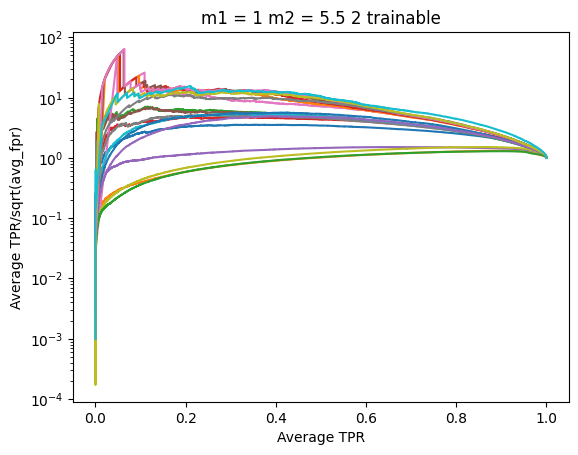

In [293]:
avg = np.mean(scores_list_runs, axis = 0)
epsilon = 1e-6
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr + epsilon,(avg_tpr + epsilon)/np.sqrt(avg_fpr + epsilon))
    plt.title(f"m1 = {m1} m2 = {m2} 2 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")